In [1]:
# Copyright 2021 Radiotherapy AI Holdings Pty Ltd

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#    http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import pathlib
import random
import shutil
import urllib.request

import matplotlib.pyplot as plt
import imageio
import tensorflow as tf

In [3]:
zip_url = "https://github.com/RadiotherapyAI/unet-workshop/releases/download/mini-parotid/mini-parotid.zip"
zip_filepath = "data.zip"

data_directory = pathlib.Path("data")

if not data_directory.exists():
    urllib.request.urlretrieve(zip_url, zip_filepath)
    shutil.unpack_archive(zip_filepath, data_directory)

In [4]:
dataset_types = [path.name for path in data_directory.glob("*") if path.is_dir()]
dataset_types

['hold-out', 'training', 'validation']

In [5]:
def _load(path):
    image = imageio.imread(path)
    image = image / 255
    return image

In [6]:
training_image_paths = list((data_directory / "validation").glob("*/*.image.png"))
training_mask_paths = [
    path.parent / f"{path.name.split('.')[0]}.masks.png"
    for path in training_image_paths
]

path_pairs = [(str(image), str(mask)) for image, mask in zip(training_image_paths, training_mask_paths)]

In [7]:
dataset = tf.data.Dataset.from_tensor_slices(path_pairs)
dataset = dataset.shuffle(len(path_pairs), reshuffle_each_iteration=True)

In [8]:
@tf.function
def load(path_pair):
    image_raw = tf.io.read_file(path_pair[0])
    image = tf.io.decode_image(image_raw, channels=1, dtype=tf.uint8)
    
    masks_raw = tf.io.read_file(path_pair[1])
    masks = tf.io.decode_image(masks_raw, channels=3, dtype=tf.uint8)
    
    return image / 255, masks / 255

In [9]:
dataset = dataset.map(load)

In [10]:
image, masks = iter(dataset.take(1)).next()

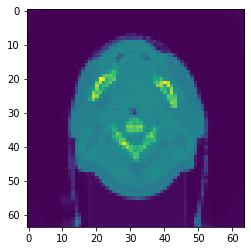

In [11]:
plt.imshow(image)

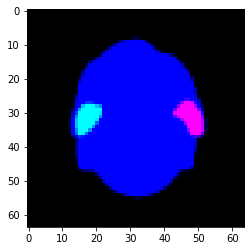

In [12]:
plt.imshow(masks)